# Import modules

In [ ]:
!pip install -r requirements.txt

In [ ]:
from utils.dataset import make_datapath_list, CrackDataset, CrackTransform
from utils.loss_function import DiceBCELoss
from utils.module import EarlyStopping
from utils.segmentation_eval import DiceScore, Accuracy, Precision, Recall, Specificity
import matplotlib.pyplot as plt
import numpy as np 
import torch.utils.data as data
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader
import os
import datetime

# Visualize dataset

In [ ]:
datapath = make_datapath_list(nfold=5)
train_paths, val_paths = datapath.get_train_val_lists(fold_index=0)
test_paths = datapath.get_test_lists()

In [ ]:
print(train_paths)
print(val_paths)

In [ ]:
train_dataset = CrackDataset(train_paths[0], train_paths[1],transform=CrackTransform(crop_size=256))
val_dataset = CrackDataset(val_paths[0], val_paths[1],transform=CrackTransform(crop_size=256))

In [ ]:
# データの可視化
i = 2
img, anno = train_dataset.__getitem__(i)
img = img.clone().numpy()
img = img.transpose((1,2,0))

anno = anno.clone().numpy()
anno = np.asarray(anno, np.float64)
anno = anno.transpose((1,2,0))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(anno, cmap='gray')
plt.title('Mask')
plt.show()

# Setup model

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# segmentation_models_pytorchを利用
model = smp.DeepLabV3Plus(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)
print(model)

# Training (Cross Validation)

In [ ]:
# set config
nfold = 5
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_criterion = DiceBCELoss()
accuracy_criterion = DiceScore()
optimizer = torch.optim.Adam(model.parameters())
patience = 10
num_epochs = 100
crop_size = 256
batch_size = 4

In [ ]:
def train_model(model, dataloaders, loss_criterion, accuracy_criterion, optimizer, num_epochs, device, patience, fold_index, timestamp):
    model.to(device)
    earlystopping = EarlyStopping(patience=patience)
    os.makedirs(f'weights/{timestamp}/fold{fold_index+1}', exist_ok=True)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_accuracy = 0.0

            for images, labels in dataloaders[phase]:
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = loss_criterion(outputs, labels)
                    accuracy = accuracy_criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_accuracy += accuracy.item() * images.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_accuracy = running_accuracy / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f}  {phase} Accuracy: {epoch_accuracy:.4f}')
                   
        earlystopping(epoch_loss)
        if earlystopping.early_stop:
            print("Early Stop")
            break
        if earlystopping.counter == 0:
            print(f"Validation Loss declined to {earlystopping.best_score}")
            torch.save(model.to('cpu').state_dict(), f'weights/{timestamp}/fold{fold_index+1}/best.pth')
            model = model.to(device)
            fold_accuracy = epoch_accuracy
            
        torch.save(model.to('cpu').state_dict(), f'weights/{timestamp}/fold{fold_index+1}/last.pth')
        model = model.to(device)

    print('Fold training complete')
    return fold_accuracy

In [ ]:
# Cross-validation
datapath = make_datapath_list(nfold)
timestamp = datetime.datetime.now().strftime("%m%d%H%M")
os.makedirs(f'weights/{timestamp}', exist_ok=True)
val_accuracy = []

for fold_index in range(nfold):
    print(f'Starting fold {fold_index + 1}/{nfold}')
    train_paths, val_paths = datapath.get_train_val_lists(fold_index=fold_index)

    train_dataset = CrackDataset(train_paths[0], train_paths[1], transform=CrackTransform(crop_size=crop_size))
    val_dataset = CrackDataset(val_paths[0], val_paths[1], transform=CrackTransform(crop_size=crop_size))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    dataloaders = {
        'train': train_loader,
        'val': val_loader
    }

    # Train the model
    fold_accuracy = train_model(model, dataloaders, loss_criterion, accuracy_criterion, optimizer, num_epochs, device, patience, fold_index, timestamp)
    val_accuracy.append(fold_accuracy)

print(f"Validation Accuracy : {sum(val_accuracy)/len(val_accuracy):.4f}")

# Test

In [ ]:
# テストデータでの複数モデルを用いた精度測定
datapath = make_datapath_list(nfold=nfold)
test_paths = datapath.get_test_lists()
test_dataset = CrackDataset(test_paths[0], test_paths[1],transform=CrackTransform(crop_size=crop_size))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

c1 = DiceScore()
c2 = Accuracy()
c3 = Precision()
c4 = Recall()
c5 = Specificity()

for fold_index in range(nfold):
    model.load_state_dict(torch.load(f'weights/{timestamp}/fold{fold_index+1}/best.pth'))

    model.eval()  # モデルを評価モードに設定

    dice_score = 0
    accuracy = 0
    precision = 0
    recall = 0
    specificity = 0

    with torch.no_grad():  # 勾配計算を行わないための指定
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            dice_score += c1(outputs, labels).item() * images.size(0)
            accuracy += c2(outputs, labels).item() * images.size(0)
            precision += c3(outputs, labels).item() * images.size(0)
            recall += c4(outputs, labels).item() * images.size(0)
            specificity += c5(outputs, labels).item() * images.size(0)
            
    dice_score /= len(test_dataset)
    accuracy /= len(test_dataset)
    precision /= len(test_dataset)
    recall /= len(test_dataset)
    specificity /= len(test_dataset)
    

    print(f'Fold {fold_index+1}: \
        Dice Score: {dice_score:.4f} \
        Accuracy: {accuracy:.4f} \
        Precision: {precision:.4f} \
        Recall: {recall:.4f} \
        Specificity: {specificity:.4f}')

In [24]:
# 出力表示
model.load_state_dict(torch.load(f'weights/{timestamp}/fold1/best.pth'))
model.eval()

with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)

    outputs = torch.sigmoid(model(images))

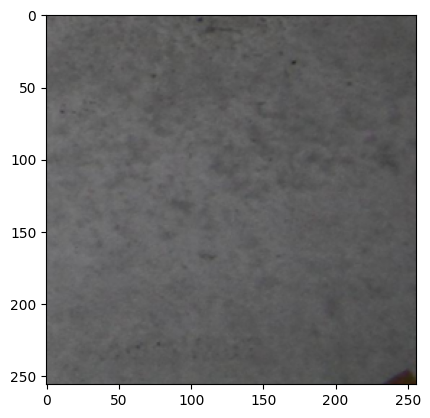

In [25]:
image = images[0].clone().numpy().transpose((1,2,0))
plt.imshow(image)

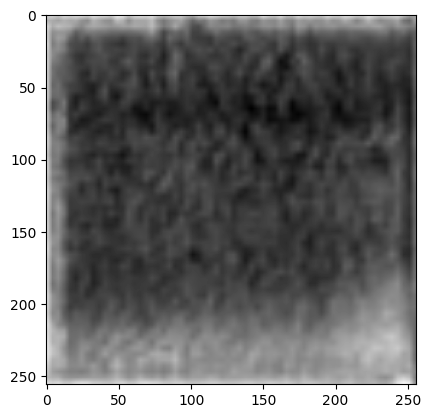

In [26]:
output = outputs[0][0].clone().numpy()
plt.imshow(output, cmap='gray')

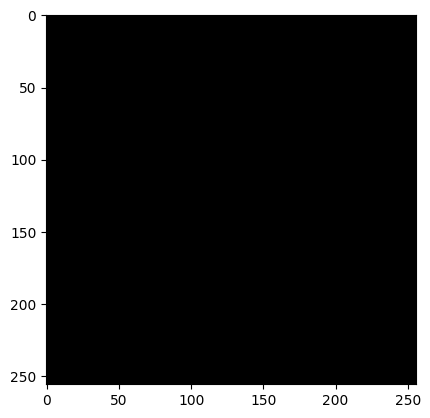

In [27]:
label = labels[0][0].clone().numpy()
plt.imshow(label, cmap='gray')